In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from albumentations import (Rotate,Compose,RandomBrightness,RandomContrast,GaussNoise,HorizontalFlip,CLAHE)
import glob
from sklearn.model_selection import train_test_split
import torchvision.models as models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [ ]:
#uzip the images
#!unzip data.zip

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
from torch.utils.data import Dataset, DataLoader

class face_loader(Dataset):

  def __init__(self,path,list_name,resize=224,transforms=None,preprocessing=None):
    self.path=path
    #resize the image must be the same size
    self.resize=resize
    self.transforms=transforms
    self.preprocessing=preprocessing
    self.list_name=list_name
    
  def __len__(self):
      return len(self.path)
  
  def __getitem__(self, idx):
    if idx not in range(0, len(self.path)):
      return self.__getitem__(np.random.randint(0, self.__len__()))
    p=self.path[idx]
    image1=cv2.imread(p)
    #All image in same size
    image1=cv2.resize(image1,(self.resize,self.resize))
    image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    name=p.split("/")[-2]
    label=self.list_name[name]
    if self.transforms:
      image1=self.transforms(image=image1)['image']
    image1=np.transpose(image1, (2, 1, 0))
    image1=torch.tensor(image1)
    return image1,label

In [ ]:
#Split Data
list_name_dir=glob.glob("/content/data/*/*")

#split dataset the data is only list name dir that conatin label and path for image
xTrain, xVal, _, _ = train_test_split(list_name_dir,[1]*len(list_name_dir), test_size = 0.2, random_state = 0,shuffle=True)

#List name is for label each label name for specific index like Harel :0,Hen :1
list_name={}
index=0
for i in range(0,len(list_name_dir),20):
  label=list_name_dir[i].split("/")[-2]
  list_name[label]=index
  index+=1

batch_s=8
transforms=Compose([Rotate(p=0.4,limit=35),HorizontalFlip(p=0.6),RandomBrightness(p=0.5),RandomContrast(p=0.3),CLAHE(p=0.3,clip_limit=10)])
face_dataset=face_loader(xTrain,list_name,transforms=transforms)
train_loader=DataLoader(face_dataset,batch_size=batch_s,shuffle=True)
val_set=face_loader(xVal,list_name,transforms=None)
val_loader=DataLoader(val_set,batch_size=batch_s,shuffle=True)

#1.1

In [ ]:
class VGG16(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGG16, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers()
        self.fc1=nn.Linear(25088, 4096)
        self.droup_out1=nn.Dropout(p=0.15)
        self.fc2=nn.Linear(4096, 4096)
        self.droup_out2=nn.Dropout(p=0.10)
        self.fc3=nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x=self.conv_layers(x)
        x=x.view(x.shape[0],-1)
        x=F.relu(self.fc1(x))
        x=self.droup_out1(x)
        x=F.relu(self.fc2(x))
        x=self.droup_out2(x)
        x=self.fc3(x)
        return x

    def create_conv_layers(self):
        layers = []
        in_channels = self.in_channels
        architecture=[64, 64, 'Max', 128, 128, 'Max', 256, 256, 256, 'Max', 512, 512, 512, 'Max', 512, 512, 512, 'Max']
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels,out_channels,kernel_size=3, stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()
                           ]
                in_channels = x
            else :
                layers += [nn.MaxPool2d(2)]
                
        return nn.Sequential(*layers)

In [ ]:
import random
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
from numpy import mean

class Focal_Loss(nn.Module):
    
    def __init__(self, alpha=1, gamma=2, mean=True):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.mean = mean

    def forward(self, inputs, targets):
        CE = nn.CrossEntropyLoss().cuda()
        CE_loss = CE(inputs, targets)
        pt = torch.exp(-CE_loss)
        focal_loss1 = self.alpha* (1-pt)**self.gamma * CE_loss
        if self.mean:
            return torch.mean(focal_loss1)
        else:
            return focal_loss1

In [ ]:
from tqdm import tqdm_notebook as tqdm


list_TP=[]
list_FN=[]

def train(epoch_number,model,optim,loss):
  model.train()
  all_loss=0
  correct=0
  true_positive=0
  false_negative=0
  all_pred=[]
  all_y_true=[]
  tqdm_loader=tqdm(train_loader)
  for  index,(img,target) in enumerate(tqdm_loader):
    img=img.float().cuda()
    target=target.long().cuda()

    optim.zero_grad()
    out=model(img)
    loss1=loss(out,target)
    loss1.backward()
    optim.step()
    all_loss+=loss1.item()
    avg_loss=all_loss/(index+1)
    pred=out.argmax(dim=1,keepdim=True)
    correct+=pred.eq(target.view_as(pred)).sum().item()/len(target)

    true_positive+=pred.eq(target.view_as(pred)).sum().item()
    false_negative+= (~pred.eq(target.view_as(pred))).sum().item()
    
    #all_pred and all target for confusion matrix
    all_pred.extend(pred.cpu().data.numpy().reshape(-1, 1).tolist())
    all_y_true.extend(target.cpu().data.numpy().reshape(-1, 1).tolist())


    avg_acc=correct/(index+1)
    tqdm_loader.set_description("Epoch {} trainLoss={:3} acc={:3} TP={} FN={}".format(epoch_number,round(avg_loss,4),round(avg_acc,4),true_positive,false_negative))
  
  array=confusion_matrix(all_y_true,all_pred,labels=range(22))

  return avg_loss,avg_acc,array


def validation(epoch_number,model,loss,append_TP_and_FN):
  model.eval()
  all_loss=0
  correct=0
  true_positive=0
  false_negative=0
  all_pred=[]
  all_y_true=[]
  tqdm_loader=tqdm(val_loader)
  for index,(img,target) in enumerate(tqdm_loader):
    img=img.float().cuda()
    target=target.long().cuda()

    with torch.no_grad():
      out=model(img)
      loss1=loss(out,target)
    
    all_loss+=loss1.item()
    avg_loss=all_loss/(index+1)

    
    pred=out.argmax(dim=1,keepdim=True)
    correct+=pred.eq(target.view_as(pred)).sum().item()/len(target)
    avg_acc=correct/(index+1)

    true_positive+=pred.eq(target.view_as(pred)).sum().item()
    false_negative+= (~pred.eq(target.view_as(pred))).sum().item()

    #all_pred and all target for confusion matrix
    all_pred.extend(pred.cpu().data.numpy().reshape(-1, 1).tolist())
    all_y_true.extend(target.cpu().data.numpy().reshape(-1, 1).tolist())

    #Add image for TP and FN to show example
    if append_TP_and_FN:
      pred=pred.cpu().data.numpy()
      target=target.cpu().data.numpy()
      for i in range(len(pred)):
        if pred[i]== target[i] and len(list_TP) < 4:
          list_TP.append((img[i],pred[i]))
        elif pred[i] != target[i] and len(list_FN) < 4:
          list_FN.append((img[i],pred[i]))

    tqdm_loader.set_description("Epoch {} valLoss={:3} acc={:3} TP={} FN={} ".format(epoch_number,round(avg_loss,4),round(avg_acc,4),true_positive,false_negative))

  array=confusion_matrix(all_y_true,all_pred,labels=range(22))
  return avg_loss,avg_acc,array

#1.2

In [ ]:
#Load model,loss,optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_16 = VGG16(in_channels=3,num_classes=len(list_name))

vgg_16=vgg_16.to(device)
vgg_16.apply(init_weights)

loss_cross= Focal_Loss().cuda()
optim=torch.optim.Adam(vgg_16.parameters(),lr=0.0001)


#Train + val the vgg16 model
list_epoch=[]
loss_train={"avg_loss":[],"accuracy":[]}
loss_val={"avg_loss":[],"accuracy":[]}
num_epoch=20
for epoch in range(num_epoch):
  list_epoch.append(epoch)
  l1,l2,matrix_train=train(epoch,vgg_16,optim,loss_cross)
  loss_train["avg_loss"].append(l1)
  loss_train["accuracy"].append(l2)
  l1,l2,matrix_val=validation(epoch,vgg_16,loss_cross,True)
  loss_val["avg_loss"].append(l1)
  loss_val["accuracy"].append(l2)

In [ ]:
def plot_confusion_matrix(array,title):
  plt.figure(figsize=[10,10])
  plt.title(title)
  df_cm = pd.DataFrame(array, range(22), range(22))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

In [ ]:
#label1 - train/validation/'' ,graph_loss_all_model - loss of model.
#start - start index of graph_loss_all_model.
def plot_graph(start,graph_loss_all_model,label1,skip=1):
  plt.figure(figsize=[10,5])
  plt.subplot(1,2,1)
  for i in range(start,len(graph_loss_all_model),skip):
      plt.plot(graph_loss_all_model[i][0],graph_loss_all_model[i][1],label=label1+graph_loss_all_model[i][3])
  # naming the x axis 
  plt.xlabel('Epoch') 
  # naming the y axis 
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  for i in range(start,len(graph_loss_all_model),skip):
      plt.plot(graph_loss_all_model[i][0],graph_loss_all_model[i][2],label=label1+graph_loss_all_model[i][3])
  plt.xlabel('Epoch')
  # naming the y axis 
  plt.ylabel('convergence')
  plt.legend()
  plt.show()

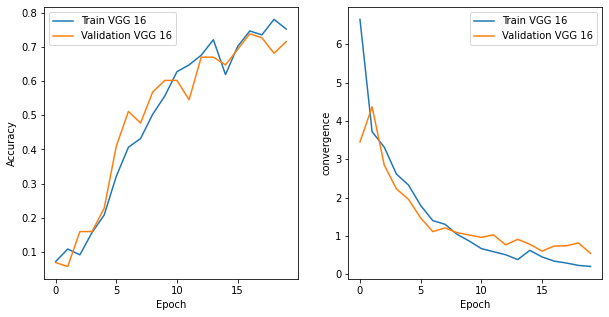

In [13]:
vgg16_graph=[]
vgg16_graph.append([list_epoch,loss_train["accuracy"],loss_train["avg_loss"],'Train VGG 16'])
vgg16_graph.append([list_epoch,loss_val["accuracy"],loss_val["avg_loss"],'Validation VGG 16'])
plot_graph(0,vgg16_graph,'',skip=1)

In [ ]:
list_key_name=list(list_name.keys())

#Show The FN and TP
def show_reult(list_img_label):
  plt.figure(figsize=[10,10])
  for i in range(len(list_img_label)):
    img,label=list_img_label[i]
    title=list_key_name[int(label)]
    plt.subplot(1,4,i+1)
    plt.title(title)
    
    img=np.transpose(img.cpu().data.numpy(), (2, 1, 0))
    img=np.array(img,np.int32)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

In [ ]:
#Show True positive
show_reult(list_TP)

In [ ]:
#Show False Negative
show_reult(list_FN)

#1.5

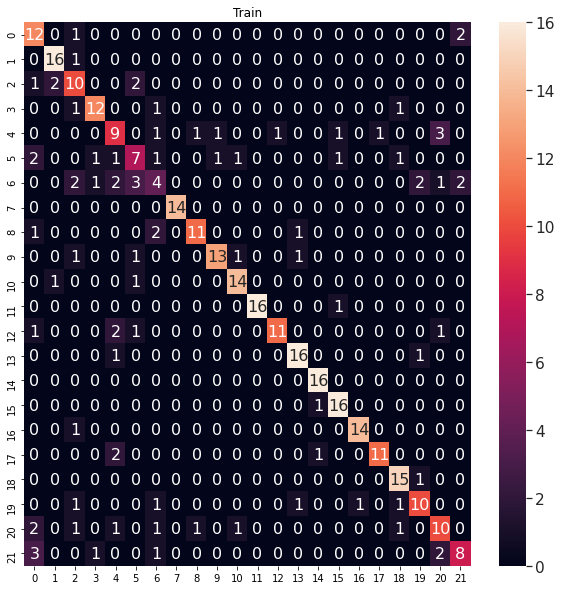

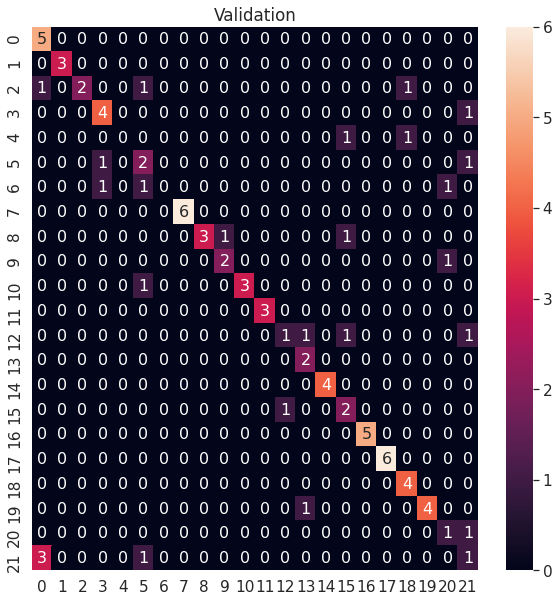

In [17]:
plot_confusion_matrix(matrix_train,'Train')
plot_confusion_matrix(matrix_val,'Validation')

#1.6

In [ ]:
import torchvision.models as models
#Other five model
resnet18 = models.resnet18(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
resnext = models.resnext50_32x4d(pretrained=True)
googlenet = models.googlenet(pretrained=True)
densenet = models.densenet161(pretrained=True)

In [ ]:
num_class=len(list_name)
resnet18.fc=nn.Linear(in_features=512,out_features=num_class)
resnext.fc=nn.Linear(in_features=2048,out_features=num_class,bias=True)
googlenet.fc=nn.Linear(in_features=1024,out_features=num_class,bias=True)
densenet.classifier=nn.Linear(in_features=2208,out_features=num_class,bias=True)
mobilenet.classifier[1]=nn.Linear(in_features=1280,out_features=num_class,bias=True)

#1.6.1

In [ ]:
#train other 5 model
list_model=[(resnet18,'resnet',0.0001),(mobilenet,'mobilenet',0.0005),(resnext,'resnext',0.0001),(googlenet,'googlenet',0.0005),(densenet,'densenet',0.0001)]
graph_loss_all_model=[]
list_all_TP=[]
list_all_FN=[]
list_all_matrix=[]
epcoh_number=3
for (model,model_name,leran_rate) in list_model:
    list_epoch=[]
    l1,l2=0,0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    loss_cross=Focal_Loss().cuda()
    adam=torch.optim.Adam(model.parameters(),lr=leran_rate)
    loss_train={"avg_loss":[],"accuracy":[]}
    loss_val={"avg_loss":[],"accuracy":[]}
    for epoch in range(epcoh_number):
        list_epoch.append(epoch)
        l1,l2,matrix_train=train(epoch,model,adam,loss_cross)
        loss_train["avg_loss"].append(l1)
        loss_train["accuracy"].append(l2)
        if epoch+1 == epcoh_number:
          list_TP=[]
          list_FN=[]
          l1,l2,matrix_val=validation(epoch,model,loss_cross,True)
          list_all_TP.append(list_TP)
          list_all_FN.append(list_FN)
          list_all_matrix.extend([matrix_val,matrix_train])
        else:
          l1,l2,_=validation(epoch,model,loss_cross,False)
        loss_val["avg_loss"].append(l1)
        loss_val["accuracy"].append(l2)
    #Add all loss of all model 
    graph_loss_all_model.append([list_epoch,loss_train["accuracy"],loss_train["avg_loss"],model_name])
    graph_loss_all_model.append([list_epoch,loss_val["accuracy"],loss_val["avg_loss"],model_name])


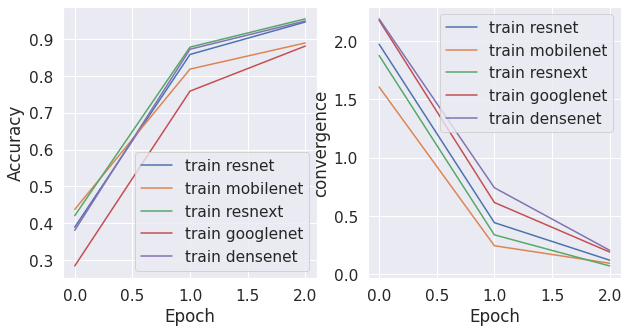

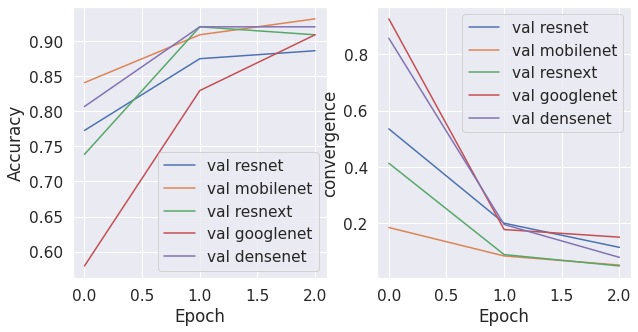

In [21]:
#plot Graph
plot_graph(0,graph_loss_all_model,'train ',skip=2)
plot_graph(1,graph_loss_all_model,'val ',skip=2)

#True Positive

In [ ]:
name_model=['resnet','mobilenet','resnext','googlenet','densenet']
for i in range(len(list_all_TP)):
  print(name_model[i]+' TP')
  show_reult(list_all_TP[i])

#False Negative

In [ ]:
for i in range(len(list_all_FN)):
  print(name_model[i]+ 'FN')
  show_reult(list_all_FN[i])

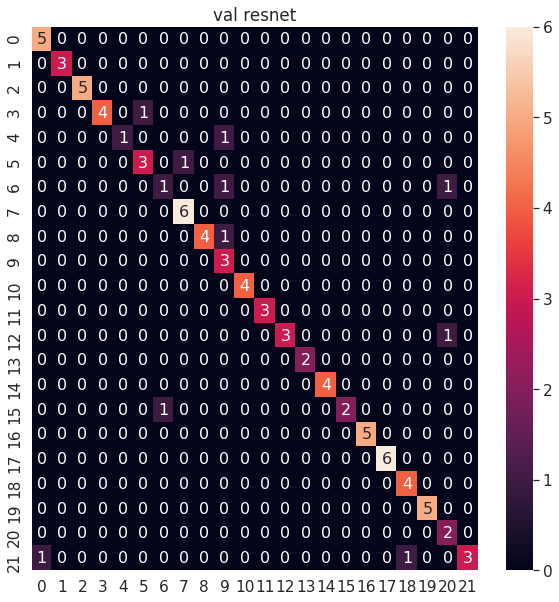

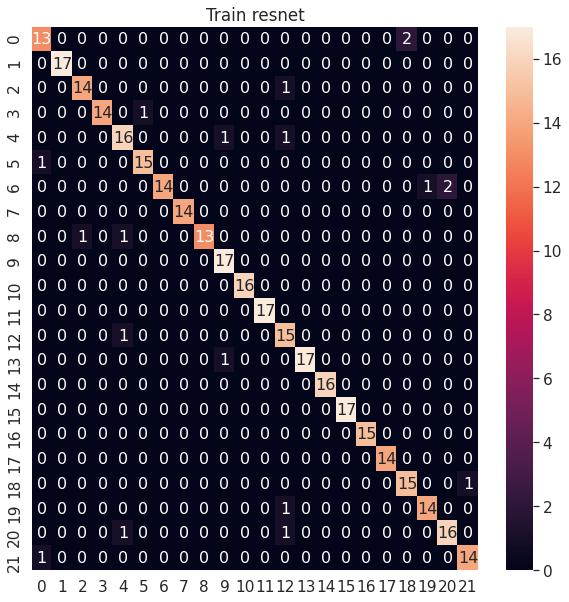

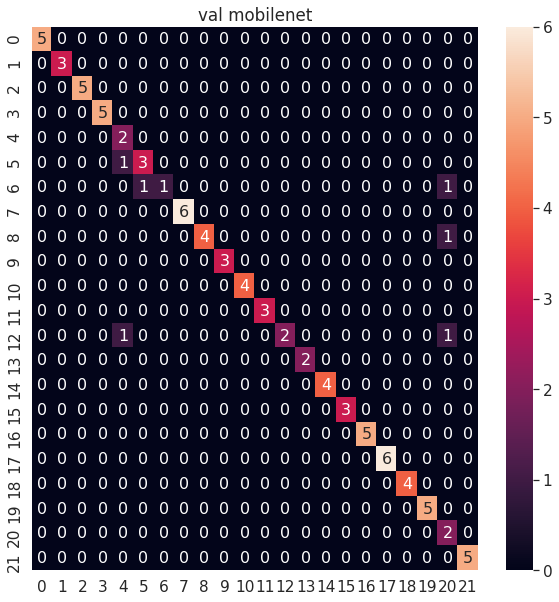

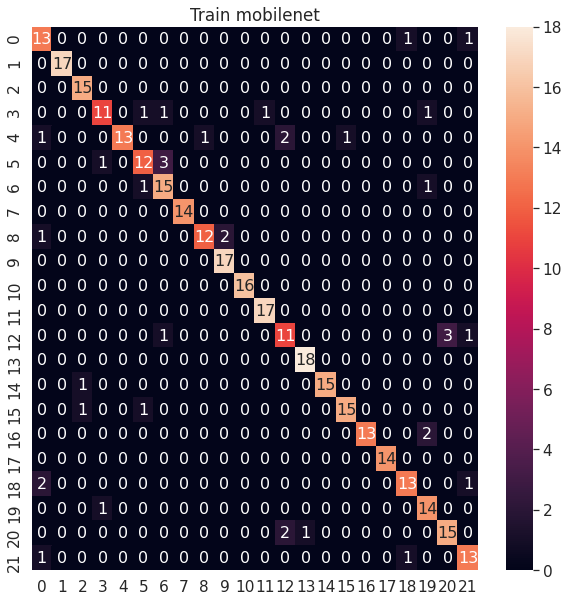

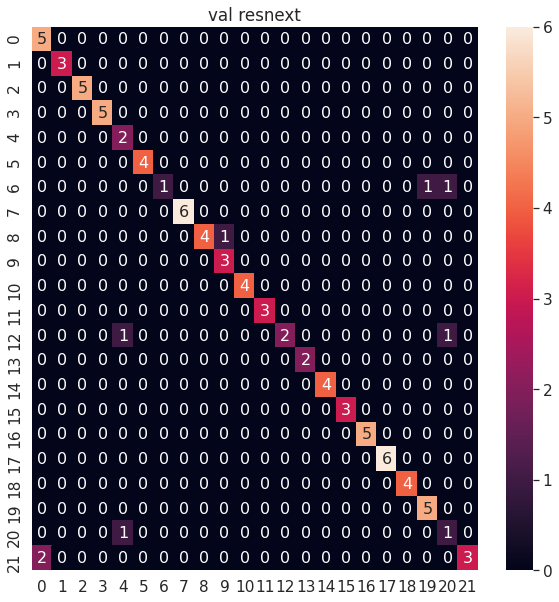

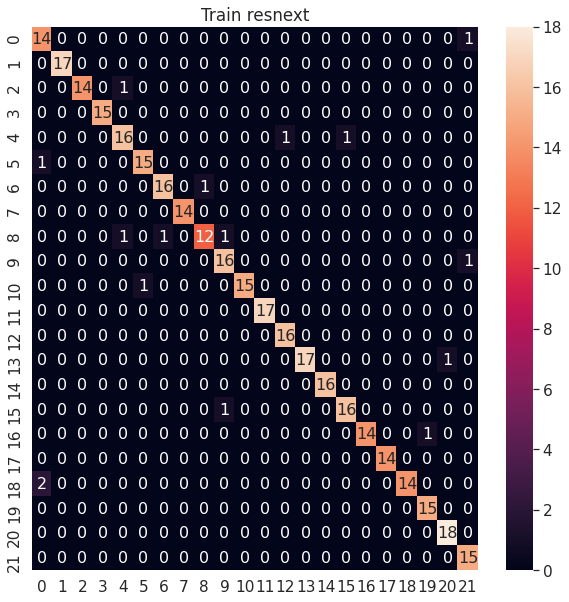

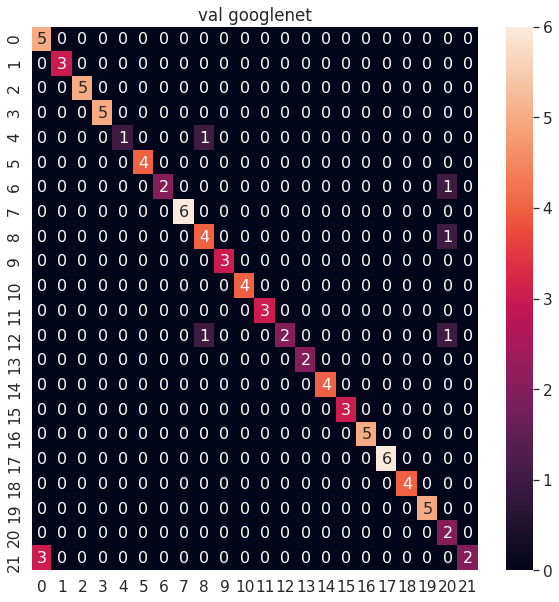

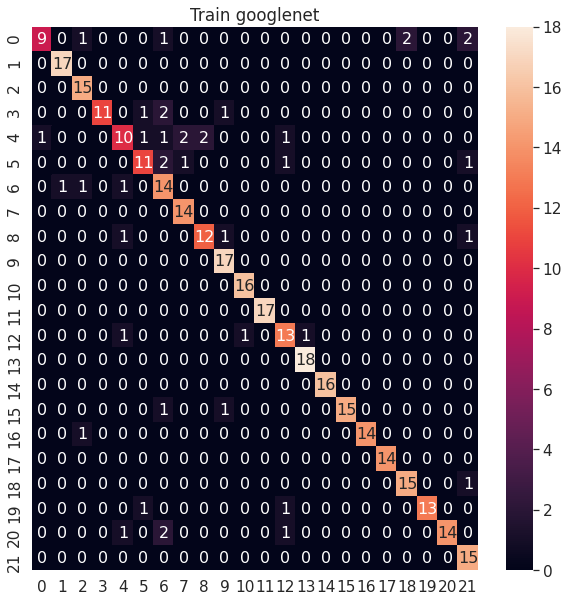

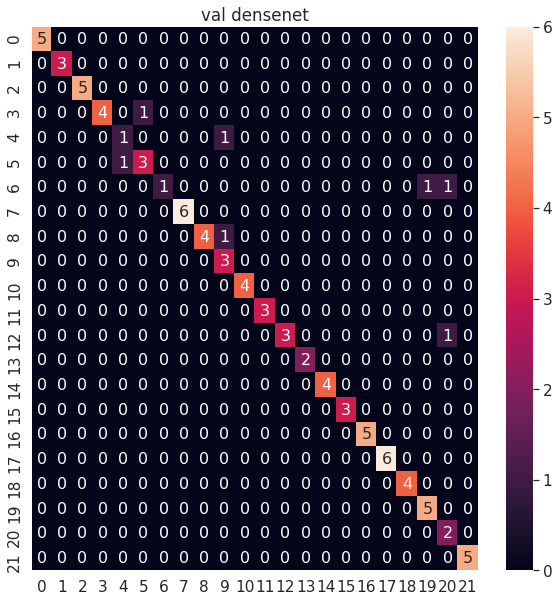

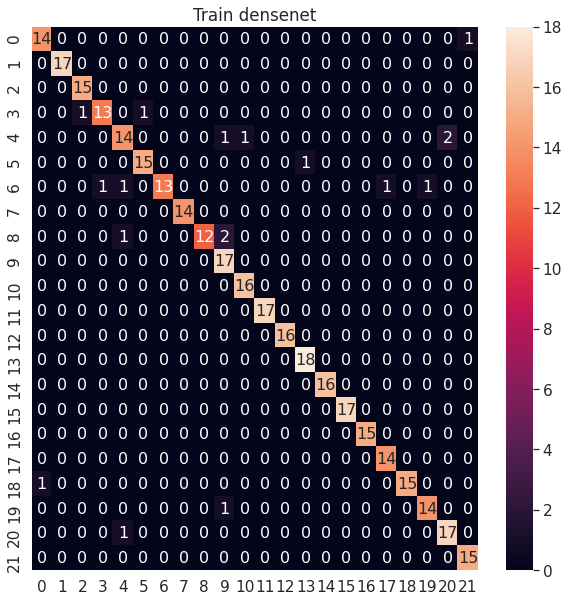

In [24]:
for i in range(0,len(list_all_matrix),2):
  plot_confusion_matrix(list_all_matrix[i],'val '+str(name_model[int(i/2)]))
  plot_confusion_matrix(list_all_matrix[i+1],'Train '+str(name_model[int(i/2)]))


#1.7

In [ ]:
class ensemble(nn.Module):
    
    def __init__(self,model,w):
        super(ensemble,self).__init__()
        self.models=model
        self.w=w
        
    def __call__(self,x):
        result=[]
        for w1,m1 in zip(self.w,self.models):
            m1.eval()
            with torch.no_grad():
                y=w1*m1(x)
                #y=F.softmax(y,dim=1)
                result.append(y.cpu().numpy())
        result=np.array(result)
        return torch.from_numpy(result.sum(axis=0)).cuda()

In [ ]:
#Create ensemble model
list_model=[resnet18,mobilenet,resnext,googlenet,densenet]
w=[0.2,0.2,0.2,0.2,0.2]
ensemble_model=ensemble(list_model,w)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ensemble_model=ensemble_model.to(device)
#adam=torch.optim.Adam(ensemble_model.parameters(),lr=0.0001)
loss_cross=Focal_Loss(alpha=1, gamma=2, mean=True).cuda()

In [ ]:
list_TP=[]
list_FN=[]
loss_train={"avg_loss":[],"accuracy":[]}
loss_val={"avg_loss":[],"accuracy":[]}
for i in range(3):
  l1,l2,matrix_val=validation(i,ensemble_model,loss_cross,True)
  loss_val["avg_loss"].append(l1)
  loss_val["accuracy"].append(l2)

graph_loss_all_model.append([list_epoch,loss_train["accuracy"],loss_train["avg_loss"],'ensemble'])
graph_loss_all_model.append([list_epoch,loss_val["accuracy"],loss_val["avg_loss"],'ensemble'])


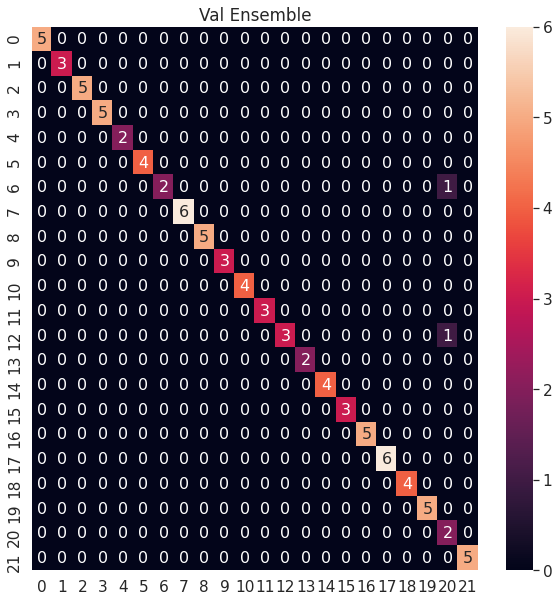

In [28]:
plot_confusion_matrix(matrix_val,'Val Ensemble')

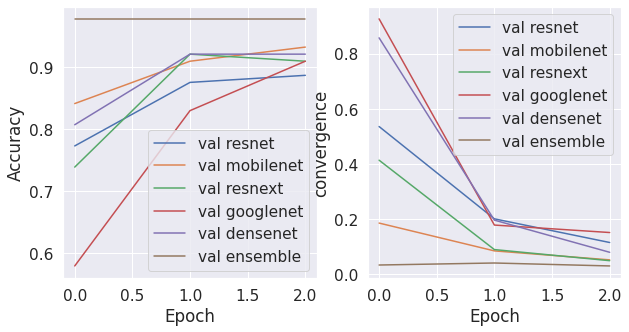

In [29]:
#plot Acu for all val
plot_graph(1,graph_loss_all_model,'val ',skip=2)